# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### Parte A - Exploración de Datos

Importo las librerías necesarias

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
sns.set()
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
# from fbprophet import Prophet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

Cargo los datos de 2017, 2018 y 2019

In [190]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

Observo el tipo de datos de cada campo y las primeras filas

In [191]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [192]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [193]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [194]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [195]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [196]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [197]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas

In [198]:
dataset = pd.concat([data_2019, data_2018, data_2017])

Nos quedamos solamente con la estación Illia y la forma de pago Efectivo

In [199]:
mask = np.logical_and(dataset["estacion"] == 'Illia', dataset["forma_pago"] == 'EFECTIVO')
dataset = dataset[mask]

Quitamos las columnas que no vamos a utilizar

In [200]:
dataset.drop(columns = ['periodo', 'hora_inicio', 'forma_pago', 'estacion'], inplace = True)
dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora

In [201]:
dataset['fecha2'] = pd.to_datetime(dataset["fecha"]) + pd.to_timedelta(dataset["hora_fin"], unit = 'h')

Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2

In [202]:
dataset.drop(columns = ['fecha', 'hora_fin'], inplace = True)
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


Corregimos el nombre de fecha2 a fecha

In [203]:
dataset.rename(columns = {'fecha2': 'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


Reordenamos el dataset por fecha

In [204]:
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01
1,Domingo,Provincia,Liviano,9,2017-01-01
2,Domingo,Provincia,Liviano,644,2017-01-01
3,Domingo,Provincia,Pesado,6,2017-01-01
4,Domingo,Provincia,Pesado,1,2017-01-01


Graficamos nuestros datos, tal como están

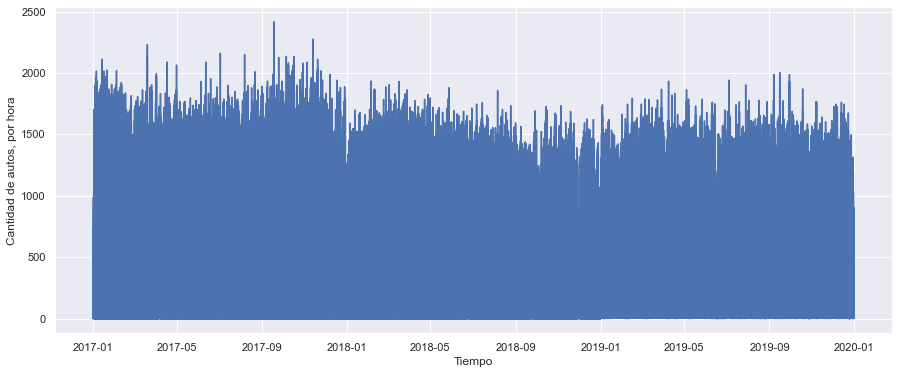

In [205]:
plt.figure(figsize = (15,6))
plt.plot(dataset["fecha"], dataset["cantidad_pasos"])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable

In [206]:
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


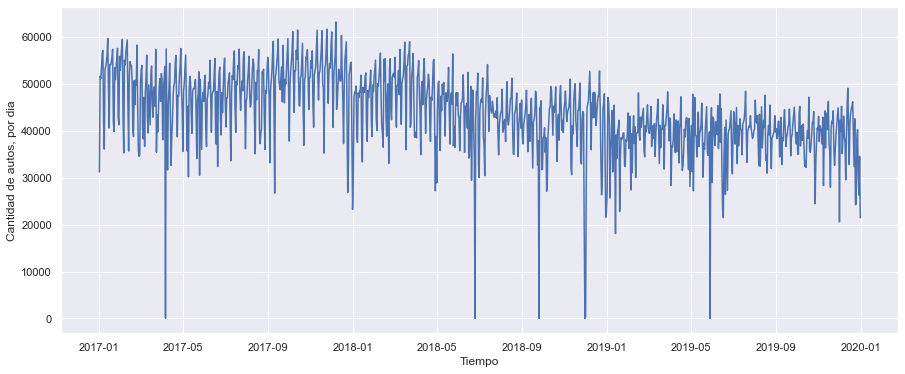

In [207]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario["cantidad_pasos"])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

#### A.1) Outliers e inputación de valores faltantes

Se observa que existen 6 valores outliers, aquellos cuya `cantidad_pasos` es inferior a 10.000.

In [208]:
diario[diario["cantidad_pasos"] < 10000]

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


Se podría eliminar dichos registros pero la serie quedaría incompleta, es por ello que se procederá a inputar dichos valores con la media móvil de 7 días.

In [209]:
diario["mm7"] = diario["cantidad_pasos"].rolling(window = 7).mean()
diario["cantidad_pasos"] = np.where(diario["cantidad_pasos"] < 10000, diario["mm7"], diario["cantidad_pasos"])
diario.drop("mm7", axis = 1, inplace = True)

Graficamos para observar que ya no tenemos outliers

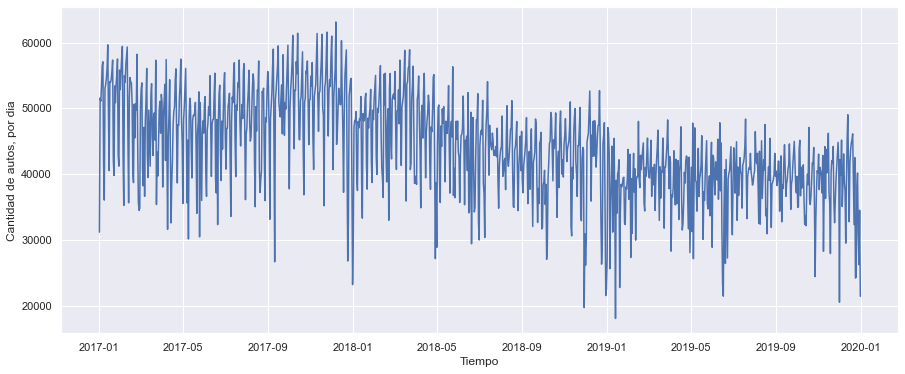

In [210]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario["cantidad_pasos"])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

#### A.2)  Descomposición de la serie

Obtener componentes de una Serie de Tiempo es un tema amplio y, como siempre, depende del problema en el que estás trabajando. Algunas series se comportan como  𝑇𝑒𝑛𝑑𝑒𝑛𝑐𝑖𝑎+𝐸𝑠𝑡𝑎𝑐𝑖𝑜𝑛𝑎𝑙𝑖𝑑𝑎𝑑+𝑅𝑢𝑖𝑑𝑜 , mientras que otras tienen comportamientos más complejos, como  𝑇𝑒𝑛𝑑𝑒𝑛𝑐𝑖𝑎∗𝐸𝑠𝑡𝑎𝑐𝑖𝑜𝑛𝑎𝑙𝑖𝑑𝑎𝑑+𝑅𝑢𝑖𝑑𝑜 . Existen muchas formas de obtener las componentes, pero no todas funcionarán en todos los casos. Además, cada técnica tiene sus ventajas y desventajas. Vamos a hacer una enumeración y demostración no exhaustiva de algunos métodos, simplemente para que te lleves una idea de qué cosas se pueden hacer fácilmente.

- El método más sencillo se conoce como media móvil. Consiste en tomar una ventana de tiempo suficientemente grande y promediar la serie sobre esa ventana. De esta forma, obtienes la tendencia. Tomate un tiempo para pensar qué significa suficientemente grande. Una característica de este método es que no asume ninguna forma para la serie de tiempo - a diferencia del que te contaremos a continuación - así que suele funcionar en muchos casos.

- Supongamos que tienes motivos para creer que la tendencia sigue un comportamiento lineal. Entonces, basta con ajustar una regresión lineal a la serie (antes también la puedes haber promediado con el método anterior) para obtener la tendencia. Este método también sirve si tienes motivos para creer que la tendencia sigue una forma arbitraria pero conocida (por ejemplo, cuadrática, exponencial, tipo seno o coseno, etc.).

Una vez que obtienes la tendencia, en ambos casos puedes tomar la serie original, restar la tendencia y obtener una nueva serie sin tendencia, donde esperamos que sea la componente estacional la que domine.

Luego, para obtener componentes estacionales, se suele asumir una forma armónica (tipo seno o coseno). Es decir, se puede hacer un procedimiento similar al que hiciste con la tendencia (ajustar y restar a la serie sin tendencia) para obtener ruido + componentes restantes.

#### Media móvil

El proceso de tomar una ventana, trasladarlo a lo largo de una serie de tiempo y hacer alguna operación en esa ventana se conoce como rolling window. En general, se utiliza junto con la media, pero también se podría obtener el máximo, mínimo o cualquier otro estadístico.

#### Tendencia Lineal

Este método consiste simplemente en ajustar una regresión lineal a la serie. Ten en cuenta que la validez de este método es muy limitada.

Comenzaremos con el método de medias móviles

In [211]:
diario["mm7"] = diario["cantidad_pasos"].rolling(window = 7).mean()

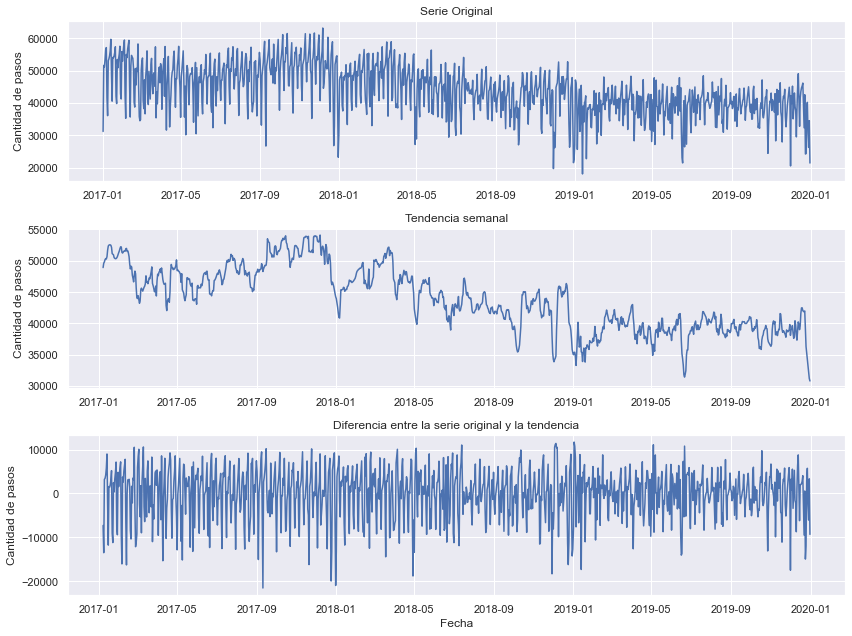

In [212]:
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario.index, diario["cantidad_pasos"])
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,2)
plt.title('Tendencia semanal')
plt.plot(diario["mm7"])
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(diario.index, diario["cantidad_pasos"] - diario["mm7"])
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')

plt.tight_layout()
plt.show()

Existen varias librerías que ya incorporan técnicas para descomponer series. Una muy conocida es `Statsmodels`, que cuenta con muchas herramientas para análisis estadísticos. Otra, exclusiva de Series de Tiempo y más nueva, es `Prophet`, desarrollada por Facebook.

#### Statsmodels

In [213]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [214]:
result = seasonal_decompose(diario["cantidad_pasos"], model = 'additive')

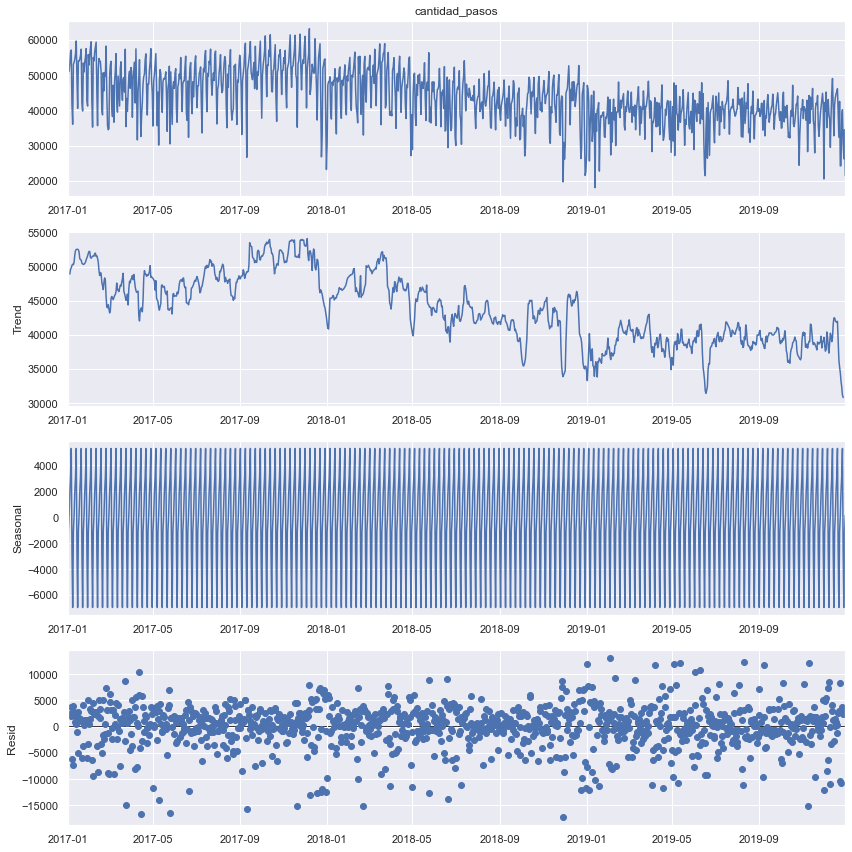

In [215]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

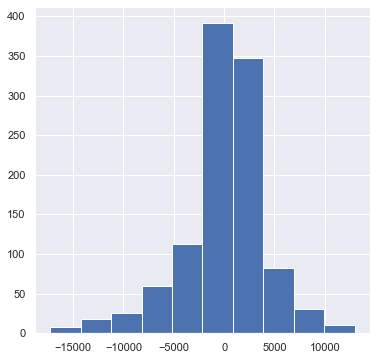

In [216]:
matplotlib.rcParams['figure.figsize'] = [6,6]
plt.hist(result.resid)
plt.show()

#### A.3) Autocorrelación

La correlación es una cuantificación de la relación entre el comportamiento de dos variables. En un lenguaje coloquial:

Cuanda ambas crecen y decrecen a la vez, decimos que están positivamente correlacionadas (valor cercano a 1).
Si una decrece y la otra crece, y viceversa, están negativamente correlacionadas (valor cercano a -1).
Y si no parece haber una relación entre su comportamiento, no están correlacionadas (valor alrededor de 0).
Vimos que hay más de una forma de calcular la correlación, la más conocida la correlación de Pearson o lineal.

En series de tiempo, el concepto de correlación aplica perfectamente. Dos series de tiempo están correlacionadas si su comportamiento en el tiempo es parecido (crecen y decrecen juntas) o anti-correlacionadas si una es máxima cuando la otra es mínima, y viceversa. También existe el concepto de autocorrelación, que es - a grosso modo - la correlación de una serie consigo misma. Pero toda variable correlacionada consigo misma da 1, por lo que estaría faltando algo. Lo que falta son los lags. Vamos a calcular la correlación con la serie de tiempo original y la misma serie desfasada o corrida en el tiempo.

En la librería `statsmodels` esto lo logramos con la función `acf`.

In [217]:
from statsmodels.tsa.stattools import acf

nlags =  52*20
autocorr = acf(diario["cantidad_pasos"], nlags = nlags)

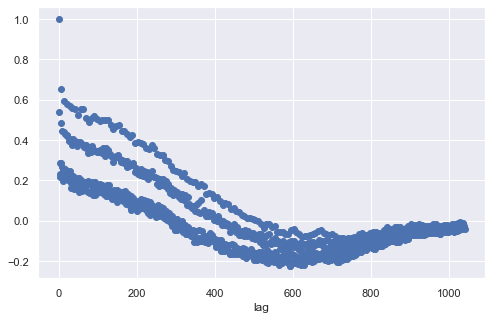

In [218]:
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

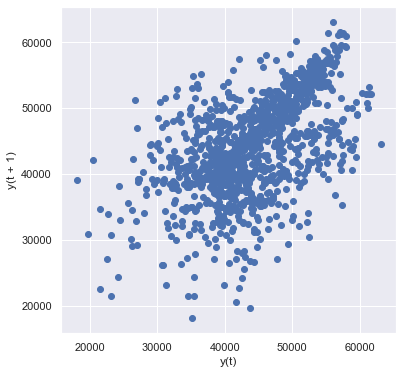

In [219]:
pd.plotting.lag_plot(diario["cantidad_pasos"], lag=1)
plt.show()

Text(0.5, 0, 'lag')

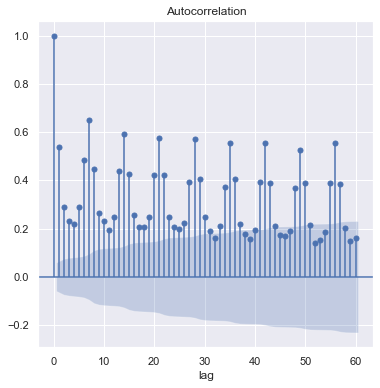

In [220]:
plot_acf(diario["cantidad_pasos"], lags=60)
plt.xlabel('lag')

Como puede observarse la función de autocorrelación proporciona los coeficientes de correlación de la serie consigo misma para distintos retardos.

Es el caso de la figura, se ve que los coeficientes (o palos de la función) son significativos para casi todos los retardos. Las bandas mas oscuras que se observan en la figura proporcionan los límites para considerar significativo un retardo. Es decir si un palo está dentro de las bandas lo consideraremos no significativo en general.

La FAS tiene un problema, y es que si por ejemplo $p1$ es distinto de cero, entonces

$$ z1 -> z2 -> ... -> zt−1 -> zt -> zt+1 -> ... $$

es decir existe una cadena de influencia separada por un retardo. Pero si $ z1 -> z2 y z2 -> z3 $, entonces $ z1 -> z3 $. Por tanto, la FAS en general, si $ p1 $ es distinto de cero, encontrará que $ p2, p3, ... $ etc, serán distintos de cero. Sin embargo es necesario distinguir entre varias cadenas de influencia posibles:

- La cadena de influencia general, a través de $ p1 $.
- Las cadenas de influencia directa. Es decir cómo influye $ z1 $ sobre $ z3 $ directamente, es decir sin pasar a través de $ z2 $.

Para resolver este problema se construye la Función de Autocorrelación Parcial.

Text(0.5, 0, 'lag')

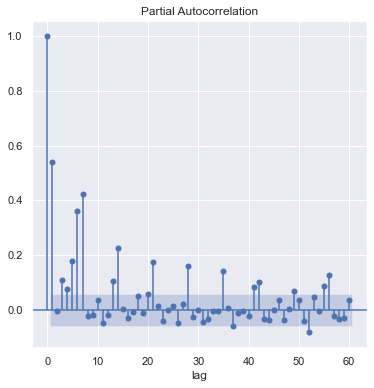

In [221]:
plot_pacf(diario["cantidad_pasos"], lags= 60)
plt.xlabel('lag')

Si los valores se encuentran fuera de las zonas mas oscuras, quiere decir que con un 95% de confianza, podemos afirmar que existe dependencia de la variable en el tiempo o autocorrelación. Esto implica que se trata de una serie no estacionaria en media.

## Parte B - Modelos de Machine Learning

#### B.1) Modelo Benchmark

Como primera aproximación que nos servirá para luego comparar futuras predicciones, utilizaremos un modelo Benchmark. El mismo consiste en predecir el valor futuro en base al valor de la fecha anterior.

In [222]:
1 - (diario.iloc[-92:, :].shape[0] / diario.shape[0])

0.9159817351598174

Observations: 1095
Training Observations: 1001
Testing Observations: 94


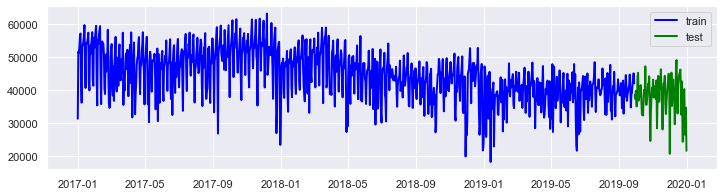

In [223]:
diario.cantidad_pasos = diario.cantidad_pasos.dropna()
train_size = int(len(diario.cantidad_pasos) * 0.915)
train, test = pd.DataFrame(diario.cantidad_pasos[0:train_size]), pd.DataFrame(diario.cantidad_pasos[train_size:len(diario.cantidad_pasos)])
print('Observations: %d' % (len(diario.cantidad_pasos)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

plt.figure(figsize = (12, 3))
plt.plot(train.index, train.cantidad_pasos,
         color='blue', lw=2, label="train")
plt.plot(test.index, test.cantidad_pasos,
         color='green', lw=2, label="test")
plt.legend()
plt.show()

In [224]:
look_back = 90 # usamos 90 datos para predecir el valor siguiente

N = diario.cantidad_pasos.shape[0]

X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)

for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = diario.cantidad_pasos.iloc[i:i+look_back]
    y[i] = diario.cantidad_pasos.iloc[i+look_back]

N_train = len(train.cantidad_pasos) - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = len(test.cantidad_pasos) #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(911, 90) (911,)
(93, 90) (93,)


In [225]:
diario.cantidad_pasos.index[N_train+look_back: length_total]

DatetimeIndex(['2019-09-29', '2019-09-30', '2019-10-01', '2019-10-02',
               '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06',
               '2019-10-07', '2019-10-08', '2019-10-09', '2019-10-10',
               '2019-10-11', '2019-10-12', '2019-10-13', '2019-10-14',
               '2019-10-15', '2019-10-16', '2019-10-17', '2019-10-18',
               '2019-10-19', '2019-10-20', '2019-10-21', '2019-10-22',
               '2019-10-23', '2019-10-24', '2019-10-25', '2019-10-26',
               '2019-10-27', '2019-10-28', '2019-10-29', '2019-10-30',
               '2019-10-31', '2019-11-01', '2019-11-02', '2019-11-03',
               '2019-11-04', '2019-11-05', '2019-11-06', '2019-11-07',
               '2019-11-08', '2019-11-09', '2019-11-10', '2019-11-11',
               '2019-11-12', '2019-11-13', '2019-11-14', '2019-11-15',
               '2019-11-16', '2019-11-17', '2019-11-18', '2019-11-19',
               '2019-11-20', '2019-11-21', '2019-11-22', '2019-11-23',
      

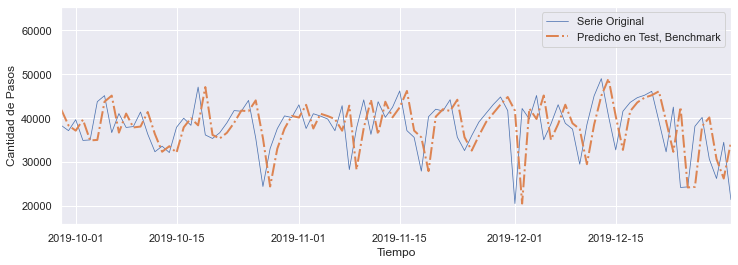

In [226]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

plt.figure(figsize=(12,4))
plt.plot(diario.cantidad_pasos.index[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(diario.cantidad_pasos.index[N_train+look_back], diario.cantidad_pasos.index[length_total-1])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

In [227]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 2]
MSE = mean_squared_error(y_test, y_test_pred_benchmark)
print('Error en Test en Benchmark:',np.sqrt(MSE))

Error en Test en Benchmark: 6784.179095513326


#### B.2) One-step prediction

Vamos a entrenar un `RandomForestRegressor` para predecir el siguiente valor en la serie. Utilizaremos datos desde `2017-01-01` hasta `2019-08-31` como conjunto de entrenamiento. Y el último trimestre del 2019 como test.

In [228]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

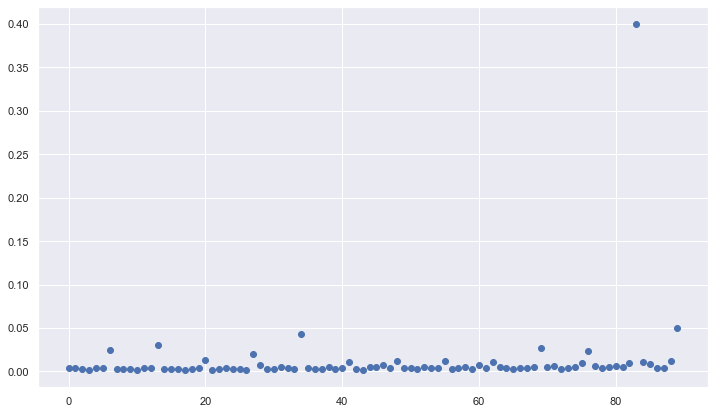

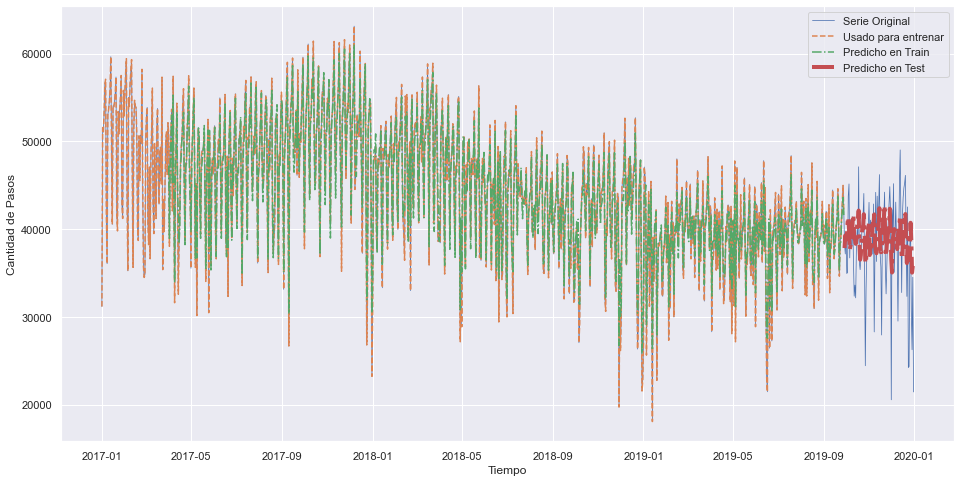

In [229]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)

y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

plt.figure(figsize=(16,8))
plt.plot(diario.cantidad_pasos.index[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.cantidad_pasos.index[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.cantidad_pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

In [230]:
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 6784.179095513326
Error en Test: 4790.999949529785


#### B.3) Multi-step prediction

Con el modelo ya entrenado, vamos a usar el método recursivo para hacer Multi-Step prediction.

In [231]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

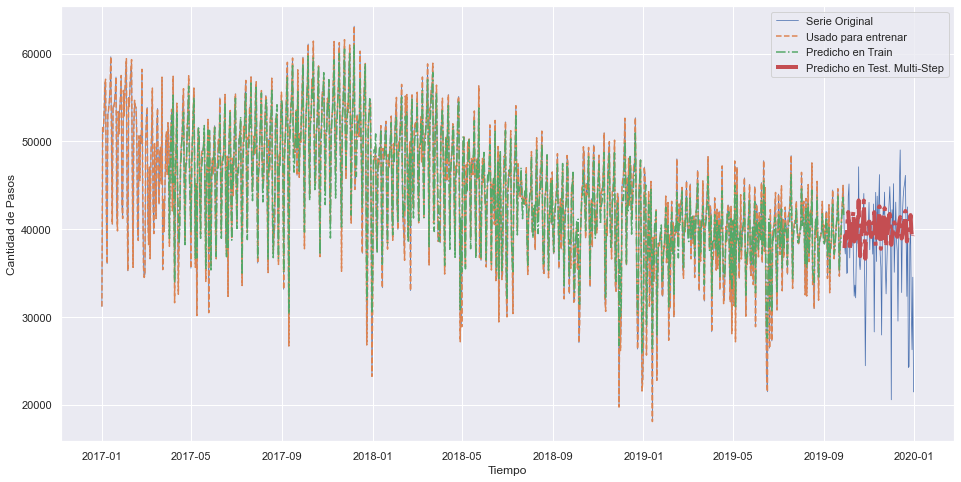

In [232]:
plt.figure(figsize=(16,8))
plt.plot(diario.cantidad_pasos.index[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.cantidad_pasos.index[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.cantidad_pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total-1], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

In [233]:
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Test: 5235.08917904369


#### B.4) Modelo Prophet

In [234]:
diario["ds"] = diario.index
diario["y"] = diario.cantidad_pasos

diario.drop(["cantidad_pasos"],axis=1, inplace=True)
diario.reset_index(drop=True, inplace=True)
diario

,mm7,ds,y
0,NaN,2017-01-01,31183.0
1,NaN,2017-01-02,51568.0
2,NaN,2017-01-03,51093.0
3,NaN,2017-01-04,53332.0
4,NaN,2017-01-05,56486.0
...,...,...,...
1090,34441.428571,2019-12-27,40182.0
1091,33209.714286,2019-12-28,30681.0
1092,32341.428571,2019-12-29,26259.0
1093,31197.428571,2019-12-30,34523.0


In [235]:
diario[diario.ds == "2019-09-30"]

,mm7,ds,y
1002,40887.857143,2019-09-30,37170.0


In [236]:
train = diario.loc[:1002,:]
test = diario.loc[1002:,:]

In [237]:
from fbprophet import Prophet

In [238]:
prophet = Prophet()
prophet.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [239]:
y_train_pred = prophet.predict(train)
y_test_pred = prophet.predict(test)
y_train = train["y"]
y_test = test["y"]

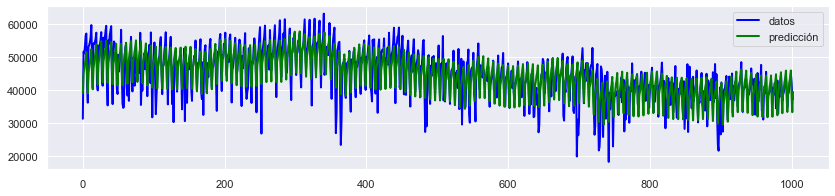

In [240]:
plt.figure(figsize = (14, 3))
plt.plot(y_train.index, y_train,
         color='blue', lw=2, label="datos")
plt.plot( y_train_pred.index,  y_train_pred["yhat"],
         color='green', lw=2, label="predicción")
plt.legend()
plt.show()

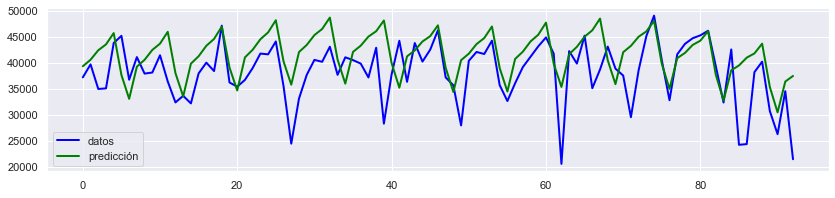

In [241]:
plt.figure(figsize = (14, 3))
plt.plot(y_test_pred.index, y_test,
         color='blue', lw=2, label="datos")
plt.plot(y_test_pred.index,  y_test_pred["yhat"],
         color='green', lw=2, label="predicción")
plt.legend()
plt.show()

In [242]:
MSE_tr = mean_squared_error(y_train, y_train_pred["yhat"])
print('Error en Train:',np.sqrt(MSE_tr))

MSE_te = mean_squared_error(y_test, y_test_pred["yhat"])
print('Error en Test:',np.sqrt(MSE_te))

Error en Train: 4663.799829116431
Error en Test: 6044.099415558932


#### B.5) Elección del modelo ganador

Si observamos el RMSE (medida elegida como objetivo) se puede concluir que `One-step prediction` nos arroja la mejor performance. Se obtiene un RMSE de $4790.99$, inferior a todos los demás desarrollos realizados.

Es por ello que, se utilizará como base dicho resultado para el Proyecto 4 y para futuras mejoras que se quieran aplicar al modelo.

### Parte C - Investigación

Como una primera mejora a los modelos desarrollados en el presente proyecto, me gustaría crear variables que capturen patrones temporales como por ejemplo días de la semana, meses, días festivos/feriados, etc.

A su vez, quizás sea adecuado diferenciar y ajustar diversos modelos para cada estación.

Para incorporar estas mejoras propuestas, se podrían crear variables dummy o bien, aplicar técnicas de encoding como por ejemplo `OneHotEncoder`.

Otras metodologías que me gustaría investigar son: modelos ARIMA y sus derivados (SARIMA, SARIMAX, etc) además del clásico XGBoost. En mi opinión, este tipo de modelos podrían captar mejor la estacionalidad de la serie, picos y puntos de inflexión en la misma, etc.

Como una primera aproximación para los siguientes desarrollos, dejo las liberías a utilizar y su documentación que nos servirán de gúia para aplicar los modelos anteriormente mencionados:

#### ARIMA:

In [243]:
from statsmodels.tsa.arima_model import ARIMA

Documentación: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMA.html

#### XGBoost

In [244]:
import xgboost as xgb

Documentación: https://xgboost.readthedocs.io/en/latest/parameter.html